<a href="https://colab.research.google.com/github/Tolemy21/MAE-598-DO/blob/main/MAE_598_Project_2_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAE 598 Design Optimization: Project 2: Bicycle Model with Model Predictive Control (MPC)

By Tolemy Nibi


## Linear Dynamics

The bicycle problem with the same dynamics. Recall that the dynamics of the bicycle $\textbf{x}(t+1)=f(\textbf{x}(t),u(t))$ is:

$$
\begin{aligned}
& x(t+1) = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \omega \Delta t,
& \end{aligned}
$$


where the bicycle state $\textbf{x}(t)$ is represented by its coordinates $x(t)$ and $y(t)$ and orientation $\theta(t)$, i.e., $\textbf{x}(t) = [x(t), y(t), \theta(t)]^T$, and $t$ specifies time. The control input $\textbf{u}(t)$ of the bicycle includes velocity $v(t)$ and angular velocity $\omega(t)$. $\Delta t$ is a time interval. $g$ is the gravity.

The key step in MPC is to use linearized dynamics. To do so, we use Taylor's expansion of the dynamics $f(\textbf{x},u(t))$ at the current state $\textbf{x}_0$ and zero control input:
$$
A = \nabla_x f = \left[\begin{array}{lllll}1 & 0 & 0\\
                                           0 & 1 & 0 \\
                                           0 & 0 & 1\end{array}\right]
$$
and
$$
B = \nabla_u f = \left[\begin{array}{lllll}cos(\theta)*\Delta t & 0 \\
                                           sin(\theta)*\Delta t & 0 \\
                                           0 & \Delta t \end{array}\right]
$$

Then we have
$$
f(\textbf{x},u) \approx f(\textbf{x}_0,0) + A(\textbf{x}-\textbf{x}_0) + Bu
$$

Since $f(\textbf{x}_0,0) = A\textbf{x}_0 + c$, where $c = [0,0,0]$, we have
$$
f(\textbf{x},u) \approx A\textbf{x} + Bu
$$
This will be the linear dynamics we use in formulating MPC.

## MPC

The optimization problem can now be formulated as follows:

$$
\begin{aligned}
\min_{(\textbf{x}(t),u(t))} \quad & \quad\quad \|\textbf{x}(T)\|^2 \\
\text{s.t.} \quad & \quad\quad \textbf{x}(t+1) = A\textbf{x}(t) + Bu(t) + c\\
\quad & \quad\quad \textbf{x}(t)[1] \geq 0\\
\quad & \quad\quad |u(t)[0]| \leq 2, |u(t)[1]| \leq 1, \quad \forall t = 0,...,T-1,
\quad & \quad\quad \textbf{x}(0) = x_0
\end{aligned}
$$
where $B$ is computed based on the current $\theta$. $\textbf{x}(t)[1] \geq 0$ constrains the altitude of the rocket to be non-negative, $|u(t)[0]| \leq 2$ bounds the thrust, and $|u(t)[1]| \leq 1$ bounds the angular velocity.

We solve MPC with ```cvx```. Sample code is as follows:


    def mpc(x_0, T):
        x = cp.Variable((n_state, T + 1))
        u = cp.Variable((n_action, T))
        theta0 = x_0[4]
        A = np.array([[1, 0, dt, 0, 0],
                    [0, 1, 0, dt, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 1]])
        B = np.array([[0, 0],
                    [0, 0],
                    [np.sin(theta0)*dt * BOOST_ACCEL, 0],
                    [np.cos(theta0)*dt * BOOST_ACCEL, 0],
                    [0, dt * OMEGA_RATE]])
        c = np.array([0,0,0,-GRAVITY_ACCEL_Y*dt,0])
        cost = 0
        constr = []
        for t in range(T):
            constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + c,
                    cp.abs(u[0, t]) <= 2,
                    cp.abs(u[1, t]) <= 1,
                    x[1, t] >= 0]
        # cost = cp.sum_squares(x[:, T])
        cost = 10 * cp.square(x[0, T]) + cp.sum_squares(x[:, T])

        # sums problem objectives and concatenates constraints.
        constr += [x[:, 0] == x_0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve()
        return x, u

Since the problem is convex, it can be solved efficiently.

## Real-Time Control with MPC

Since MPC uses a linearized version of the real dynamics, we can only trust its near future planning. Here we will only take the nearest control input solved by MPC to perform one step forward in time. Once we reach the next state, we will solve MPC again by expanding the dynamics at the new state. The code looks like the following:

    def control(x_0, total_time_step):
        x_current = x_0
        for i in range(total_time_step):
            x, u = mpc(x_current, T-i)
            action = u[:,0].value
            x_current = simulate(x_current, action)
            action_trajectory.append(action)
            state_trajectory.append(x_current)

Here ```total_time_step``` defines the whole control time window, ```T``` defines the look-ahead time window used to define and solve MPCs. As we progress in time (through the ```for``` loop), the look-ahead time window for MPC reduces so that the solver knows that the objectives should be achieved within a decreasing amount of time.

In [ ]:
!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00


In [ ]:
!pip install cvxpy==1.4.1
!pip install cvxpylayers==0.1.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.2
    Uninstalling cvxpy-1.3.2:
      Successfully uninstalled cvxpy-1.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.7 MB/s eta 0:00:00


Generating Animation


IntProgress(value=0, max=200)

(200, 3) (200, 2)


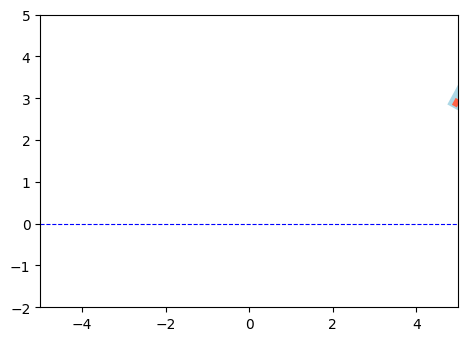

In [ ]:
def animation(state_trajectory, action_trajectory):
        length = 0.10          # m
        width = 0.02          # m

        v_exhaust = 1
        print("Generating Animation")
        steps = min(len(state_trajectory), len(action_trajectory))
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array(state_trajectory)
        action_data = np.array(action_trajectory)
        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 2]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("rocket_landing_mpc.gif", writer=writer)

animation(state_trajectory, action_trajectory)


In [ ]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer
import numpy as np

n_state = 3
n_action = 2
T = 200

dt = 0.02
x_0 = np.array( [5., 3., 1] )

total_time_step = 200

action_trajectory = []
state_trajectory = []

# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.  # gravity constant in X direction
BOOST_ACCEL = 0.18  # thrust constant
OMEGA_RATE = 0.1  # max rotation rate

def mpc(x_0, T):

    x = cp.Variable((n_state, T + 1))
    u = cp.Variable((n_action, T))
    theta0 = x_0[2]

  #   A = np.array([[1, 0, dt, 0, 0],
  #               [0, 1, 0, dt, 0],
  #               [0, 0, 1, 0, 0],
  #               [0, 0, 0, 1, 0],
  #               [0, 0, 0, 0, 1]])

  #   B = np.array([[0, 0],
  #               [0, 0],
  #               [np.sin(theta0)*dt * BOOST_ACCEL, 0],
  #               [np.cos(theta0)*dt * BOOST_ACCEL, 0],
  #               [0, dt * OMEGA_RATE]])

  #  c = np.array([0,0,0,-GRAVITY_ACCEL_Y*dt,0])


# 1  0   -v*FRAME_TIME*np.sin(state[0, 2])
# 0  1    v*FRAME_TIME*np.cos(state[0, 2])
# 0  0    1

    # A = np.array([[1, 0, -1*action[0, 0]*FRAME_TIME*np.sin( theta0 )],
    #               [0, 1,  1*action[0, 0]*FRAME_TIME*np.cos( theta0 ) ],
    #               [0, 0, 1]])

    A = np.array([[1, 0, 0 ],
                  [0, 1, 0 ],
                  [0, 0, 1]])

    B = np.array([ [np.cos( theta0 ) *FRAME_TIME, 0],
                   [np.sin( theta0)*FRAME_TIME, 0],
                   [0, FRAME_TIME]])


    # c = 0 # no gravity
    # c = np.array([0,0,0])
    cost = 0
    constr = []
    for t in range(T):
        # constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + c,
        #            cp.abs(u[0, t]) <= 2,
        #            cp.abs(u[1, t]) <= 1,
        #            x[1, t] >= 0]
        constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] ,
                   cp.abs(u[0, t]) <= 2,
                   cp.abs(u[1, t]) <= 1,
                   x[1, t] >= 0]

    # cost = cp.sum_squares(x[:, T])
    cost = cp.sum_squares(x[:, T])

    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()
    return x, u

def visualize(self):

    data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
    x = data[:, 0]
    y = data[:, 1]
    theta = data[:, 2]

    action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
    thrust = action_data[:,0]
    frame = range(self.simulation.T)

    fig, ax = plt.subplots(1, 3, tight_layout = 1, figsize = (15, 5))

    ax[0].plot(x, y, c = 'b')
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')


    ax[1].plot(frame, theta, c = 'g', label = "theta")
    ax[1].set_xlabel("Time interval")
    ax[1].set_ylabel(r"$\theta$")
    ax[1].legend(frameon=0)
    ax[1].set(title=f'Theta plot at {self.epoch}')

    ax[2].plot(frame, thrust, c = 'y', label = "velocity")
    ax[2].set_xlabel("Time interval")
    ax[2].set_ylabel("Velocity")
    ax[2].legend(frameon=0)
    ax[2].set(title=f'Velocity plot at {self.epoch}')
    plt.show()


def simulate(state, action):

##

    FRAME_TIME = 0.1  # delta_time_step

    state_tensor = np.zeros(3)
    state_tensor[0] = np.cos(state[2]) # cos(\theta)
    state_tensor[1] = np.sin(state[2]) # sin(\theta)
    state_tensor[2] = 0                      # 0

    state_theta = np.zeros(3)
    state_theta[0] = np.sin(state[2]) # sin(\theta)
    state_theta[1] = np.cos(state[2]) # cos(\theta)
    state_theta[2] = 0                      # 0

    velocity_tensor = np.multiply(np.array([1, 1, 0]), action[0] ) # [v, v, 0]
    omega_tensor = np.multiply(np.array([0, 0, 1]), action[1] )    # [0, 0, \omega]

    inter_mat = np.multiply(state_tensor, velocity_tensor) # [v*cos(\theta), v*cos(\theta), 0]

    Delta_state = FRAME_TIME * (inter_mat + omega_tensor) # [v*cos(\theta) *\Delta t, v*cos(\theta) *\Delta t, \omega *\Delta t]

    Parameters_model = np.zeros(3)
    Parameters_model[0] = 1   # alpha
    Parameters_model[1] = 1    # beta
    Parameters_model[2] = 1   # gamma

    Delta_state_Final = np.multiply(Delta_state, Parameters_model) # [alpha*v*cos(\theta) *\Delta t, beta*v*cos(\theta) *\Delta t, gamma*\omega *\Delta t]

    # state = state + Delta_state
    state = state + Delta_state_Final


    print(state)
    print(action)
    return state

def control(x_0, total_time_step):
    x_current = x_0
    for i in range(total_time_step):
        x, u = mpc(x_current, T-i)

        if u[:,0].value is None: # if the MPC problem is infeasible, stop
            print('MPC infeasible.')
            break

        # visualize(np.array(x[1:,:].value).T, np.array(u.value).T)
        action = u[:,0].value
        x_current = simulate(x_current, action)
        action_trajectory.append(action)
        state_trajectory.append(x_current)

control(x_0, total_time_step)
animation(state_trajectory, action_trajectory)






[5.01185721 3.00647762 0.49749636]
[ 0.1351122  -0.02503645]
[5.02364273 3.01287782 0.49499277]
[ 0.1341123  -0.02503588]
[5.03535226 3.01919884 0.49248923]
[ 0.13306702 -0.02503534]
[5.04698027 3.02543831 0.48998575]
[ 0.13196269 -0.0250348 ]
[5.05852103 3.03159381 0.48748233]
[ 0.13079734 -0.02503426]
[5.06996906 3.03766308 0.48497896]
[ 0.12957372 -0.02503372]
[5.08131861 3.04364379 0.48247564]
[ 0.12828916 -0.02503319]
[5.09256391 3.04953365 0.47997237]
[ 0.12694377 -0.02503266]
[5.10369911 3.05533036 0.47746916]
[ 0.12553665 -0.02503213]
[5.11471827 3.06103166 0.474966  ]
[ 0.12406721 -0.0250316 ]
[5.12561551 3.06663533 0.47246289]
[ 0.12253609 -0.02503108]
[5.13638464 3.07213909 0.46995983]
[ 0.12094029 -0.02503056]
[5.14701592 3.07753888 0.46745683]
[ 0.11924001 -0.02503004]
[5.1575013  3.08283159 0.46495388]
[ 0.11745468 -0.02502953]
[5.16783453 3.08801509 0.46245098]
[ 0.11560467 -0.02502902]
[5.17800902 3.09308713 0.45994812]
[ 0.11368627 -0.02502851]
[5.18801837 3.0980456  0

## **Visualization and Analysis of the results**:
As seen in the gif the bicycle model avoids the rocket that landed in the example problem. Therefore, this path planning problem has been solved.


## Issues and lessons learned when solving this problem are as follows:

1) Forgetting that Indexing starts at 0 and not 1 was large issues when it came to debugging. MATLAB is my language of choice. I should have used the print function more often when debugging.


2) Using the wrong number of state variables.
I was confusing state and action variables.


3) Incorrectly using action variables.
I was incorrectly indexing and defining variables.


4) Trying to solve the discrete-time dynamics without substituting $\dot{x}$, $\dot{y}$, and $\dot{\theta}$ in terms of v, $\theta$, $\Delta t$, and $\omega$.

$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t,
& \end{aligned}
$$

$$
\begin{aligned}
& x(t+1) = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \omega \Delta t,
& \end{aligned}
$$

I learned to always double check how you defined your continuous and discrete-time dynamics.

5) Trying to build a differentiable graph like in the rocket tutorial.
______________________________________________________________________
* ``delta_state_gravity`` is a vector $[0, 0, 0, -g \Delta t, 0]$
* ``state_tensor`` is $[0, 0, \sin(\theta), \cos(\theta), 0]$
* ``delta_state`` is $[0, 0, \sin(\theta) * \Delta t * boost~accel * a(t), \cos(\theta) * \Delta t * boost~accel * a(t), 0]$
* ``delta_state_theta`` is $[0, 0, 0, 0, \omega(t) * \Delta t * omega~rate]$
* the state of $t+1$ is denoted by ``state`` and its first two elements ($x$ and $y$ coordinates) are updated by
$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & \Delta t & 0 & 0 \\
0 & 1 & 0 & \Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{array}\right]\textbf{x}(t) +
\left[\begin{array}{llll}
0 & 0 & \Delta t & 0 & 0 \\
0 & 0 & 0 & \Delta t & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{array}\right] * (delta~state + delta~state~gravity)
$$
* the velocity and orientation are then updated by ``state = state + delta_state  + delta_state_gravity + delta_state_theta``
______________________________________________________________________

The approach shown in the example was not working for my model so I looked for another method. I ended up utilizing tensors and mul (used for perform multiplication operations on DataFrame objects).


6) Trying to use LaTeX when plotting.
Using LaTeX for xlabel and ylabel worked property, but not for titles of graphs. When I was doing ax[1].plot(frame, theta, c = 'g', label = r"theta") instead of ax[1].plot(frame, theta, c = 'g', label = r"theta") I was getting werid results.


7) Having to locate the animation file (gif) after I lost the path folder.
For future project I will copy paste the directory onto another document.


8) Not adding the obstacle (rocket) to the objective function.
I fixed this by reformulating my objective function.